In [1]:
# Import library
import numpy as np
import adi
import matplotlib.pyplot as plt


In [2]:
# Create radio object
sdr = adi.Pluto("ip:192.168.2.1")


In [3]:
sample_rate = 1e6
center_freq = 2e9

num_datasymbols = 64
sps = 8
num_taps = 5*sps+1 #number of taps for rrc


num_samps = 2*(num_datasymbols*sps + num_taps - 1) # number of samples per call to rx(): 2 frames


sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -50 # Increase to increase tx power, valid range is -90 to 0 dB


# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 50.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC, allowable range is 0 to 74.5 dB



In [4]:
# root raised cosine filter --> split filtering between RX and TX
def rrcosfilter(N, alpha, Ts, Fs):
    """
    Generates a root raised cosine (RRC) filter (FIR) impulse response.

    Parameters
    ----------
    N : int
        Length of the filter in samples.

    alpha : float
        Roll off factor (Valid values are [0, 1]).

    Ts : float
        Symbol period in seconds.

    Fs : float
        Sampling Rate in Hz.

    Returns
    ---------

    time_idx : 1-D ndarray of floats
        Array containing the time indices, in seconds, for
        the impulse response.

    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)

    return time_idx, h_rrc



[ 1  1  1  1  1 -1 -1  1  1 -1  1 -1  1  1  1  1 -1  1  1 -1]


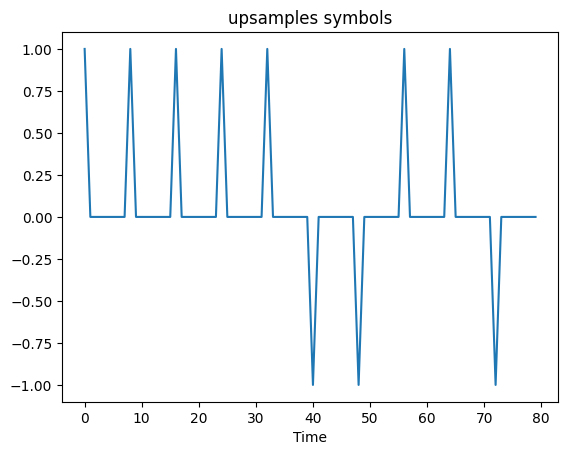

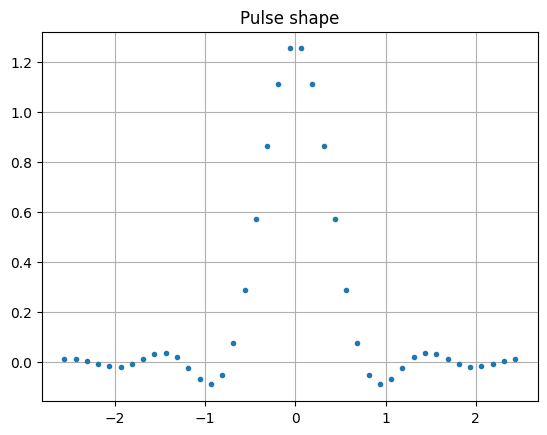

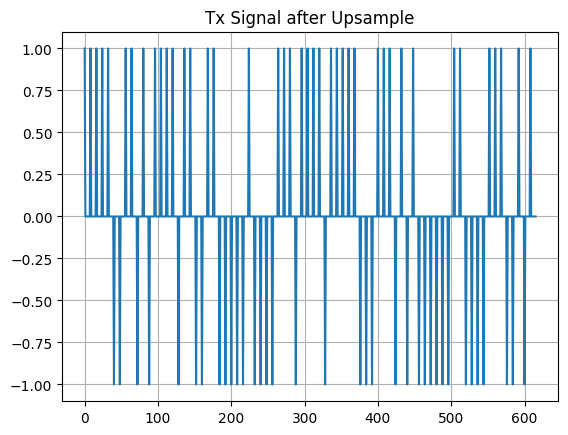

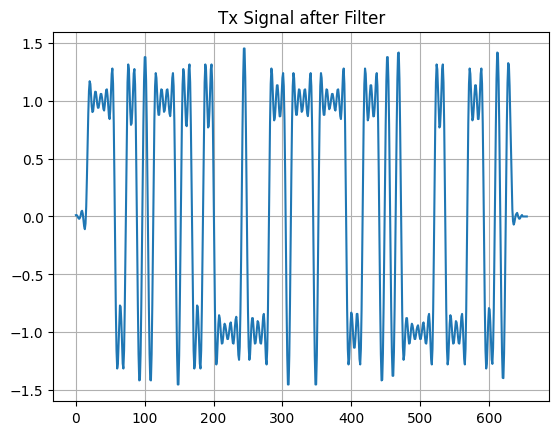

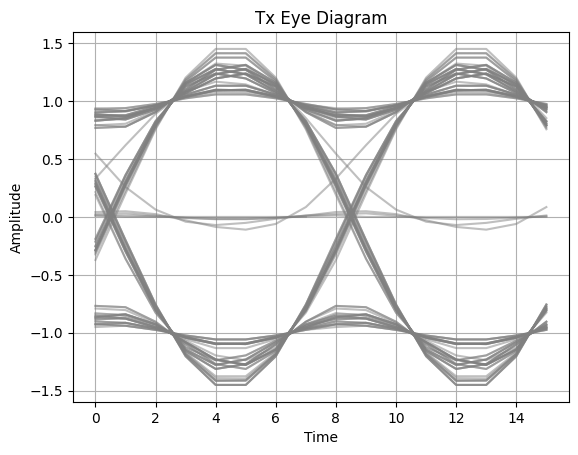

In [5]:
# Create transmit waveform (BPSK, sps samples per symbol)
bits = np.random.randint(0, 2, num_datasymbols) # 0 to 1
symbols = bits*2 - 1

# preamble (Barker)
barker = np.array([1,1,1,1,1,-1,-1,1,1,-1,1,-1,1])
preamble = barker
symbols = np.concatenate((preamble, symbols))
num_symbols = symbols.size

print(symbols[:20])

#upsampling based on sps
up_sym = np.array([])
for sym in symbols:
    temp = np.zeros(sps)
    temp[0] = sym
    up_sym = np.concatenate((up_sym, temp))

# print(up_sym[:3*sps])

# Plot time domain
plt.figure(0)
plt.plot(up_sym[:10*sps])
plt.xlabel("Time")
plt.title("upsamples symbols")

# Create our raised-cosine filter
beta = 1
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
# t = np.arange(num_taps) - (num_taps-1)//2
# h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)
t, h_pulse = rrcosfilter(num_taps, beta, Ts=1, Fs=sps)


# Plot rrc
plt.figure(1)
plt.plot(t, h_pulse, '.')
plt.grid(True)
plt.title("Pulse shape")
plt.show()

# Filter our signal, in order to apply the pulse shaping
# 1. rrc filter
x_shaped = np.convolve(up_sym, h_pulse)

# 2. rectangle filter
# x_shaped = np.repeat(symbols, sps) # 16 samples per symbol (rectangular pulses)
plt.figure(2)
plt.plot(up_sym)
plt.title("Tx Signal after Upsample")
plt.grid(True)
plt.show()

plt.figure(3)
# plt.plot(x_shaped[num_taps//2:num_taps//2 + 10*sps])
plt.plot(x_shaped)
plt.title("Tx Signal after Filter")
# for i in range(num_datasymbols):
#     plt.plot([i*sps+num_taps//2,i*sps+num_taps//2], [0, x_shaped[i*sps+num_taps//2]])
plt.grid(True)
plt.show()


# Create the eye diagram
plt.figure(4)
for k in range(len(x_shaped)):
    plt.plot(x_shaped[k * sps:(k + 2) * sps], color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tx Eye Diagram')
plt.grid(True)
plt.show()


In [6]:
tx_samples = x_shaped*2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

Npacket_samples = tx_samples.size
# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(tx_samples) # start transmitting



In [7]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
raw_data = sdr.rx()
print(raw_data)

# rx_samples = 2**-14*raw_data # TODO: normalize? You don't need to do this 
rx_samples = raw_data
# Stop transmitting
sdr.tx_destroy_buffer()



[ 456.-310.j  151.-102.j -190.+128.j ...  819.-557.j  824.-560.j
  688.-475.j]


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


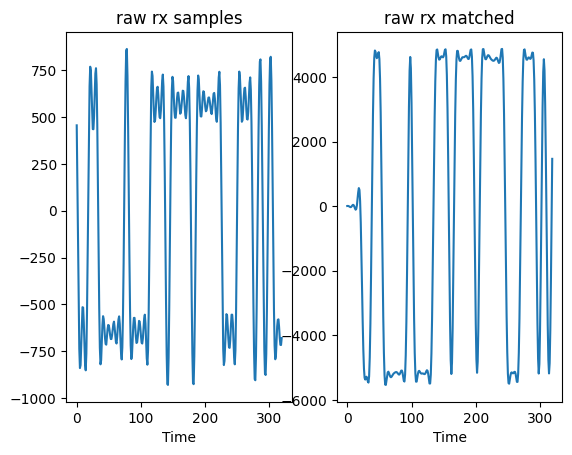

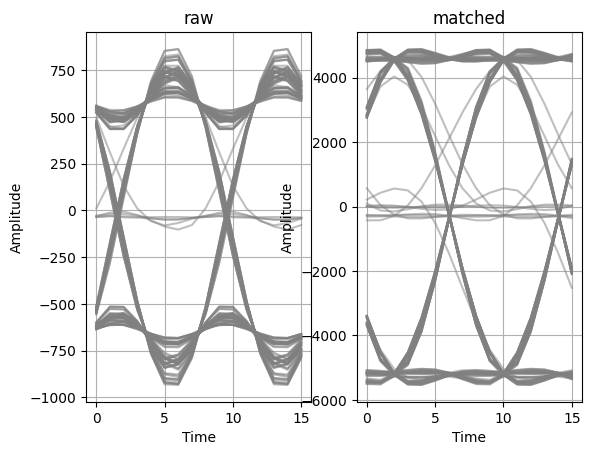

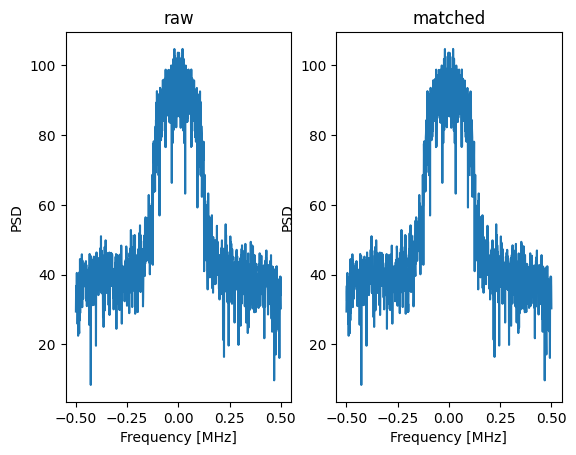

In [8]:
# matched filter
# 1. rrc filter
rx_matched = np.convolve(rx_samples, h_pulse) #recall h_pulse is impulse response of root raised cosine filter
# 2. rectangle filter
# rx_matched = rx_samples

# Calculate power spectral density (frequency domain version of signal)
psdraw = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psdraw_dB = 10*np.log10(psdraw)

psd = np.abs(np.fft.fftshift(np.fft.fft(rx_matched)))**2
psd_dB = 10*np.log10(psdraw)

f = np.linspace(sample_rate/-2, sample_rate/2, len(psdraw))

# this is after matched filtering 
# Plot time domain
plt.figure(0)
plt.subplot(1,2,1)
plt.plot(np.real(rx_samples[:40*sps]))
# plt.plot(np.imag(rx_samples[:4*sps]))
plt.xlabel("Time")
plt.title("raw rx samples")
plt.figure(0)
plt.subplot(1,2,2)
plt.plot(np.real(rx_matched[:40*sps]))
# plt.plot(np.imag(rx_samples[:4*sps]))
plt.xlabel("Time")
plt.title("raw rx matched")


# Create the eye diagram
plt.figure(1)
plt.subplot(1,2,1)
for k in range(len(rx_samples)):
    plt.plot(rx_samples[k * sps:(k + 2) * sps], color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('raw')
plt.grid(True)
plt.subplot(1,2,2)
for k in range(len(rx_matched)):
    plt.plot(rx_matched[k * sps:(k + 2) * sps], color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('matched')
plt.grid(True)
plt.show()


# Plot freq domain
plt.figure(2)
plt.subplot(1,2,1)
plt.plot(f/1e6, psdraw_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.title('raw')

plt.subplot(1,2,2)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.title('matched')

plt.show()


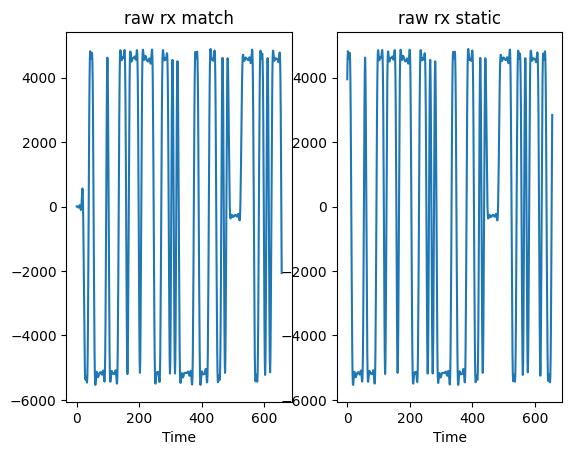

1


In [9]:
# pulse alignment

# drop samples to remove filtering transition: not necessary because time-async
rx_static = rx_matched[num_taps:-num_taps]

# Plot time domain
plt.figure
plt.subplot(1,2,1)
plt.plot(np.real(rx_matched[:Npacket_samples]))
# plt.plot(np.imag(rx_samples[:4*sps]))
plt.xlabel("Time")
plt.title("raw rx match")
plt.subplot(1,2,2)
plt.plot(np.real(rx_static[:Npacket_samples]))
# plt.plot(np.imag(rx_samples[:4*sps]))
plt.xlabel("Time")
plt.title("raw rx static")
plt.show()

# choose the sample at which energy is largest and align as so
# print(np.abs(rx_matched))
energy = np.zeros(sps)
for k in range(sps):
    energy[k] = sum( np.absolute(rx_static[k::sps]))

# symbols_sps = np.zeros((sps, np.size(rx_static)//sps+1))
# for k in range(sps):
#     symbols_sps[k] = rx_static[k::sps]

# align the samples
max_ind = np.argmax(energy)
print(max_ind)
rx_align = rx_static[max_ind:]



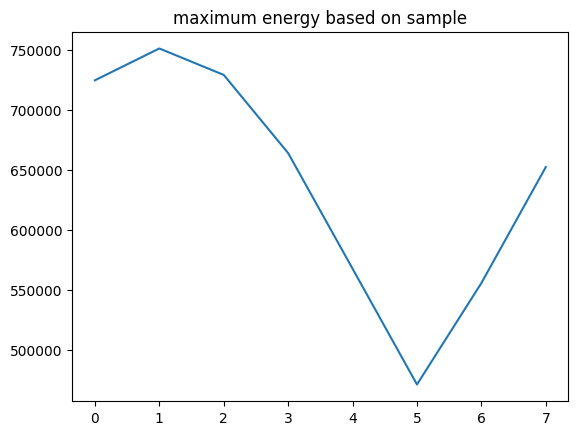

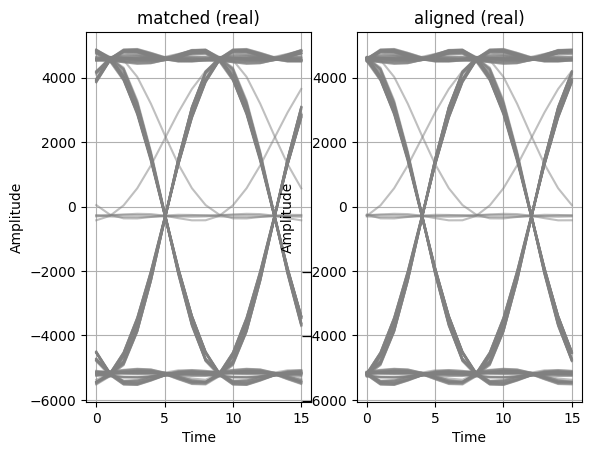

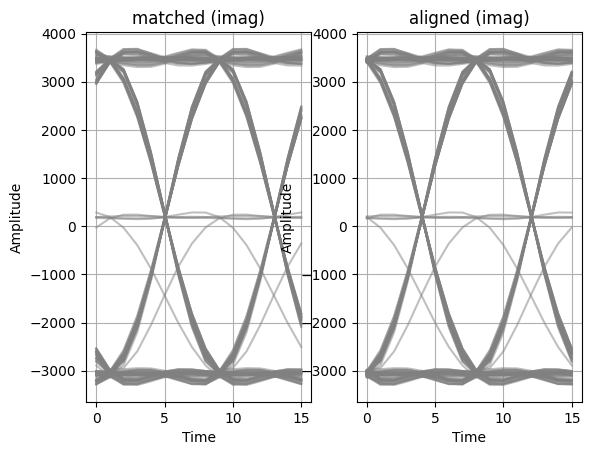

In [10]:

# Plot freq domain
plt.figure
plt.plot(energy)
plt.title("maximum energy based on sample")
plt.show()


# Create the eye diagram
plt.figure
plt.subplot(1,2,1)
for k in range(len(rx_static)):
    plt.plot(np.real(rx_static[k * sps:(k + 2) * sps]), color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('matched (real)')
plt.grid(True)
plt.subplot(1,2,2)
for k in range(len(rx_align)):
    plt.plot(np.real(rx_align[k * sps:(k + 2) * sps]), color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('aligned (real)')
plt.grid(True)
plt.show()

# Create the eye diagram
plt.figure
plt.subplot(1,2,1)
for k in range(len(rx_static)):
    plt.plot(np.imag(rx_static[k * sps:(k + 2) * sps]), color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('matched (imag)')
plt.grid(True)
plt.subplot(1,2,2)
for k in range(len(rx_align)):
    plt.plot(np.imag(rx_align[k * sps:(k + 2) * sps]), color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('aligned (imag)')
plt.grid(True)
plt.show()



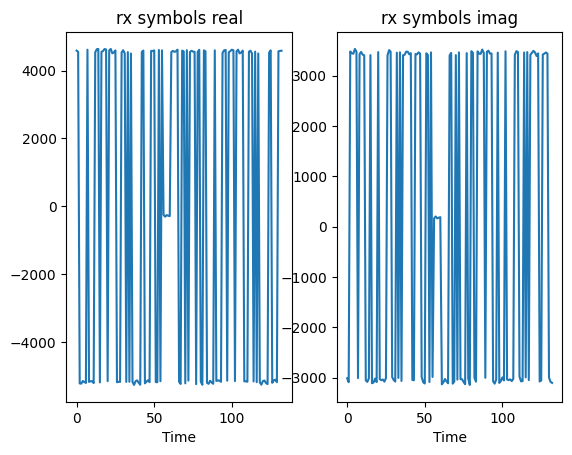

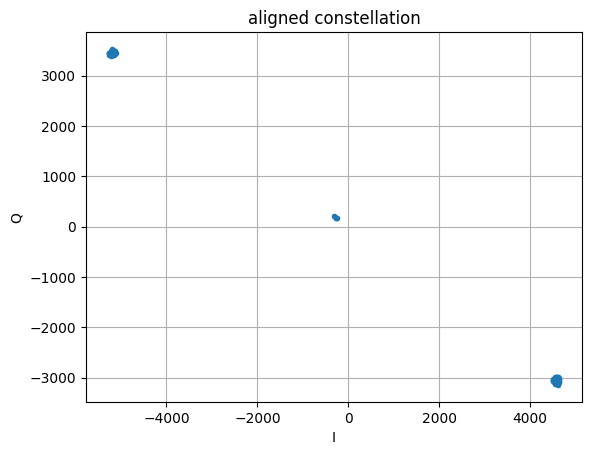

In [11]:
# constellation

#sample back to symbol
rx_symbols = rx_align[::sps]


# Plot time domain
plt.figure
plt.subplot(1,2,1)
plt.plot(rx_symbols.real)
# plt.plot(np.imag(rx_samples[:4*sps]))
plt.xlabel("Time")
plt.title("rx symbols real")
plt.subplot(1,2,2)
plt.plot(rx_symbols.imag)
# plt.plot(np.imag(rx_samples[:4*sps]))
plt.xlabel("Time")
plt.title("rx symbols imag")
plt.show()



# Create the eye diagram
plt.figure
plt.plot(rx_symbols.real, rx_symbols.imag, '.')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('aligned constellation')
plt.grid(True)
plt.show()


[ 4550.52397508  4584.78410467  4558.22894369  4573.58119367
  4620.96373735 -5180.28224451 -5243.08760926  4592.9154742
  4568.59425034 -5226.21063516  4606.0186918  -5144.7056257
  4553.52402924]


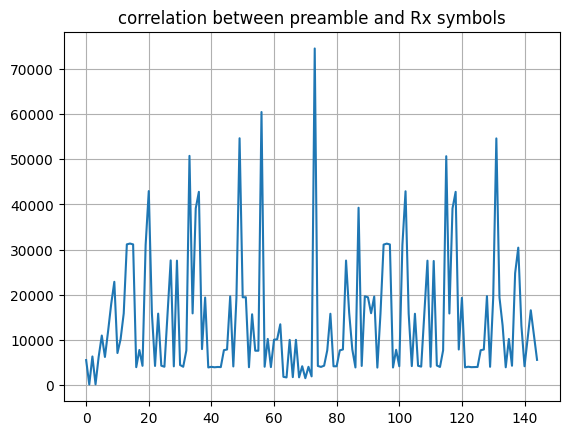

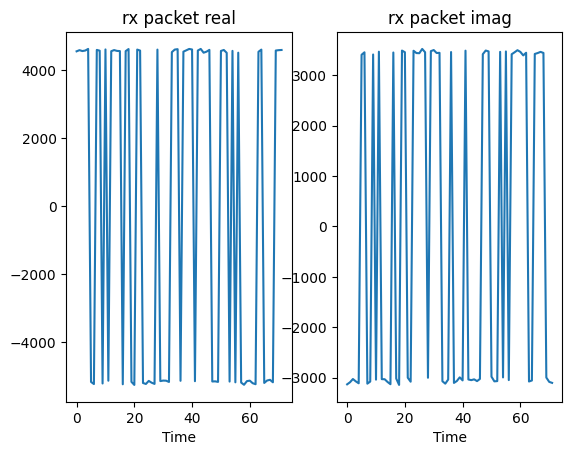

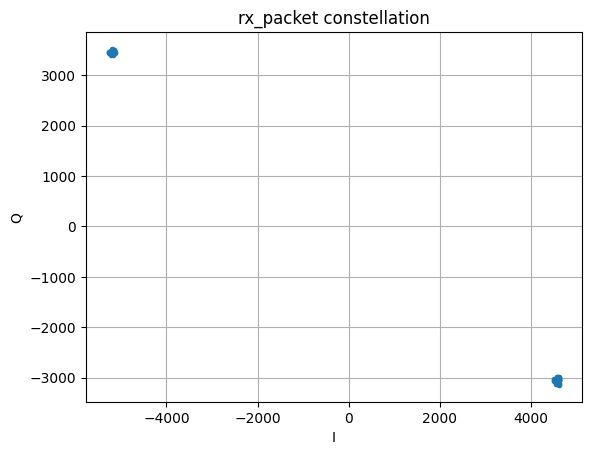

In [12]:
# frame sync
corr = np.abs(np.convolve(rx_symbols, np.flip(preamble)))
frame_ind = np.argmax(corr) - preamble.size + 1 # find the index of largest correlation (frame index)

#shift based on frame index
rx_packet = rx_symbols[frame_ind:frame_ind+num_symbols]

print(np.real(rx_packet[:preamble.size]))
# Create the correlation
plt.figure
plt.plot(corr)
plt.title('correlation between preamble and Rx symbols')
plt.grid(True)
plt.show()

# Plot time domain
plt.figure
plt.subplot(1,2,1)
plt.plot(rx_packet.real)
# plt.plot(np.imag(rx_samples[:4*sps]))
plt.xlabel("Time")
plt.title("rx packet real")
plt.subplot(1,2,2)
plt.plot(rx_packet.imag)
# plt.plot(np.imag(rx_samples[:4*sps]))
plt.xlabel("Time")
plt.title("rx packet imag")
plt.show()

# Create the eye diagram
plt.figure
plt.plot(rx_packet.real, rx_packet.imag, '.')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('rx_packet constellation')
plt.grid(True)
plt.show()



# test 
# test_sym = np.array([1, -1, -1, -1])
# test_sym = np.concatenate((test_sym, preamble))
# corr_test = np.convolve(test_sym, np.flip(preamble))
# teststart_ind = np.argmax(corr_test) - preamble.size + 1
# print(teststart_ind)
# # Create the correlation
# plt.figure
# plt.plot(corr_test)
# plt.title('correlation test')
# plt.grid(True)
# plt.show()


In [13]:
# channel estimation (single tap) least square estimator
L = 1
N = preamble.size

A = np.zeros((N-L+1, L))
for k in range(N-L+1):
    A[k,:] = np.flip(preamble[k:k+L])

print("preamble: ", preamble)
print("A: ", A)

y = rx_packet[L-1:N]
print("y: " , y)

hhat = np.linalg.lstsq(A, y, rcond=None)[0]

print("hhat: ", hhat)


preamble:  [ 1  1  1  1  1 -1 -1  1  1 -1  1 -1  1]
A:  [[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
y:  [ 4550.52397508-3130.94457289j  4584.78410467-3089.48496308j
  4558.22894369-3025.60846393j  4573.58119367-3072.34473081j
  4620.96373735-3110.04878424j -5180.28224451+3402.04639903j
 -5243.08760926+3451.23630122j  4592.9154742 -3117.57766242j
  4568.59425034-3075.92132269j -5226.21063516+3407.86310643j
  4606.0186918 -3037.95750557j -5144.7056257 +3463.32578116j
  4553.52402924-3028.21370067j]
hhat:  [4769.49388574-3185.58256109j]


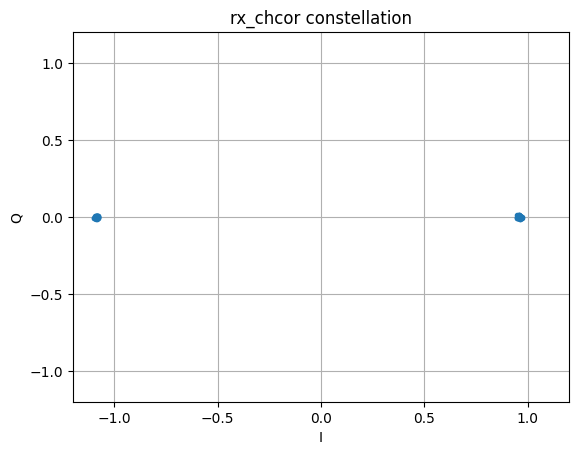

In [14]:
# channel correction (single tap)
rx_chcor = rx_packet/hhat #received / estimated h

# Create the eye diagram
plt.figure
plt.plot(rx_chcor.real, rx_chcor.imag, '.')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('rx_chcor constellation')
plt.grid(True)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
# plt.axis('scaled')
# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.show()


In [15]:
whos

Variable          Type        Data/Info
---------------------------------------
A                 ndarray     13x1: 13 elems, type `float64`, 104 bytes
L                 int         1
N                 int         13
Npacket_samples   int         656
Ts                int         8
adi               module      <module 'adi' from 'C:\\U<...>kages\\adi\\__init__.py'>
barker            ndarray     13: 13 elems, type `int32`, 52 bytes
beta              int         1
bits              ndarray     64: 64 elems, type `int32`, 256 bytes
center_freq       float       2000000000.0
corr              ndarray     145: 145 elems, type `float64`, 1160 bytes
energy            ndarray     8: 8 elems, type `float64`, 64 bytes
f                 ndarray     1104: 1104 elems, type `float64`, 8832 bytes
frame_ind         int64       61
h_pulse           ndarray     41: 41 elems, type `float64`, 328 bytes
hhat              ndarray     1: 1 elems, type `complex128`, 16 bytes
i                 int         9
k